In [2]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from scipy.ndimage import gaussian_filter1d
import os
import pandas as pd
from math import isnan
import random
import glob
import sys
sys.path.append('../')
from package_global_functions import *

extSSDpath = getExternalSSDpath()
if os.path.exists(extSSDpath):
    resPath = extSSDpath + getProjectFoldername() + '/gillespie_sim_ci/results'
else:
    resPath = '/results'
    print('Forgot the SSD!!!!!')

In [ ]:
# old function keepsafe
def get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime=100.0, Nrea=100, execSim=False, keepData=False):
    """
    keepData only works when execSim==True; then if keepData=True, Nrea simulations are executed and addet to the already existing folder
    """
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
    #####
    if execSim: # mandatory to execute simulations, even if evos folder already exists
        execSims_for_time_evos(pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea)
        call('tar -xzf sim_results_evos.tar.gz', shell=True)
        call(f'mv sim_results_evos {evoName}', shell=True)
        if keepData and os.path.exists(f'{resPath}/{evoName}'):
            existingEvos = len(glob.glob(f'{resPath}/{evoName}/*'))
            for i in range(Nrea):
                call(f'mv {evoName}/time_evo_rea_{i}.csv {evoName}/time_evo_rea_{i+existingEvos}.csv', shell=True)
                call(f'mv {evoName}/time_evo_rea_{i+existingEvos}.csv {resPath}/{evoName}/', shell=True)
        else:
            # before moving, chech if directory already exists and if so remove it:
            if os.path.exists(f'{resPath}/{evoName}'):
                call(f'rm -r {resPath}/{evoName}', shell=True)
            call(f'mv {evoName} {resPath}/', shell=True)
    #####
    if os.path.exists(os.path.exists(evoName)): # folder exits so it can be used
        evoFiles = glob.glob(f'{resPath}/{evoName}/*')
    else:
        print('No evos folder found, please execute with execSim=True')
        return
    tssMax, tssFs, statDataPool = [], {}, {}
    for k in range(len(pis)+1):
        tssFs[f'f{k}'], statDataPool[f'f{k}'] = [], []
    statTime = 0.8*maxTime
    # for f in evoFiles:
    for i in range(len(evoFiles)):
        f = f'{resPath}/{evoName}/time_evo_rea_{i}.csv'
        tevo = pd.read_csv(f)
        tssRea = []
        for k in range(len(pis)+1):
            fevo_smoothed = []
            for i in range(int(maxTime/h)):
                tmin, tmax = h*i, h*(i+1)
                fblock = np.average(tevo.query('time >= @tmin and time < @tmax')[f'f{k}'])
                fevo_smoothed.append(fblock)
            statVal = np.average(tevo.query('time > @statTime')[f'f{k}'])
            times_smooth = np.arange(0,maxTime,h)
            tss = search_time_useStatDif(times_smooth, fevo_smoothed, statVal, statTime)
            tssFs[f'f{k}'].append(tss), tssRea.append(tss)
        tssRea = [t for t in tssRea if not isnan(t)]
        if len(tssRea) > 0:
            tssRea = sorted(tssRea)
            tssMaxRea = tssRea.pop() # already removing the max time from the list...
            tssMax.append(tssMaxRea)
            # get 2000 uniformly distributed points in the stationary state
            tevoAux = tevo.query('time >= @tssMaxRea')
            len_statData = len(tevoAux)
            while len_statData < 2000 and len(tssRea) > 0:
                # print(f'could not get 2000 different ss values for {f}')
                # tssAlt = sorted(tssRea, reverse=True)[1]
                tssAlt = tssRea.pop()
                tevoAux = tevo.query('time >= @tssAlt')
            len_statData = len(tevoAux)
            if len_statData < 2000:
                print(f'could not get 2000 different ss values for {f}')
            index_statData = np.linspace(tevoAux.index[0], tevoAux.index[-1], 2000, dtype=int)
            tevoAux = tevo.query('index in @index_statData')
            for k in range(len(pis)+1):
                # statDataPool[f'f{k}'].extend(list(tevo.query('time >= @tssMaxRea')[f'f{k}'])[::3])
                statDataPool[f'f{k}'].extend(list(tevoAux[f'f{k}']))
        else:
            tssMax.append(float('nan'))
    # save data: csv? npy?
    # tssMax_df = pd.DataFrame({'tss':tssMax})
    tssFs['tssMax'] = tssMax
    tssDf = pd.DataFrame(tssFs)
    fcolumns = [col for col in tssDf.columns if col.startswith('f')]
    tssDf['tssAvg'] = tssDf[fcolumns].sum(axis=1)/3
    tssDf.to_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    statDataPool = pd.DataFrame(statDataPool)
    statDataPool.to_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    return tssMax, statDataPool

In [38]:
def search_time_useStatDif(time, evo, statVal: float, statTime: float):
    evo_dif_to_stat = abs(evo - statVal)
    evo_rel_dif_to_stat = abs(evo - statVal)/statVal
    avgdif = np.average(evo_dif_to_stat[time >= statTime])
    # times_below_avgdif = time[evo_dif_to_stat < avgdif]
    times_rel_dif_overX = time[evo_rel_dif_to_stat >= 0.9]
    if len(times_rel_dif_overX) > 0:
        mintss = max(times_rel_dif_overX)
    else:
        mintss = 0
    # if statVal is very small do not consider the relative difference as it may rocket up many times...
    if statVal > 0.1:
        refinedTimes = time[(evo_dif_to_stat < avgdif) & (time > mintss) & (time > 2.0)]
    else:
        refinedTimes = time[(evo_dif_to_stat < avgdif) & (time > 2.0)]
    # finally...
    # initially i did this...
    # if len(refinedTimes) > 3:
    #     max_times_to_use = 3
    # else:
    #     max_times_to_use = len(refinedTimes)
    # tss = np.average(refinedTimes[0:max_times_to_use])
    # but let's only use the first time from refined times...
    tss = refinedTimes[0]
    return tss


def execSims_for_time_evos(pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea):
    pichainExec = ','.join([str(pi) for pi in pis])
    qchainExec = ','.join([str(q) for q in qs])
    ci_kwargs_chainExec = ','.join([str(cikw) for cikw in ci_kwargs])
    simCall = f'python LES_model_gill.py -pis {pichainExec} -qs {qchainExec} -l {l} -lci {lci} -ci_kwargs {ci_kwargs_chainExec} '
    simCall += f'-N {N} -maxTime {maxTime} -Nrea {Nrea} -ic {ic} --time_evo'
    call(simCall, shell=True)


def get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime=100.0, Nrea=100, execSim=False, keepData=False):
    """
    keepData only works when execSim==True; then if keepData=True, Nrea simulations are executed and addet to the already existing folder
    """
    pichain = '_'.join([str(pi) for pi in pis])
    qchain = '_'.join([str(q) for q in qs])
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
    #####
    if execSim: # mandatory to execute simulations, even if evos folder already exists
        execSims_for_time_evos(pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea)
        call('tar -xzf sim_results_evos.tar.gz', shell=True)
        call(f'mv sim_results_evos {evoName}', shell=True)
        if keepData and os.path.exists(f'{resPath}/{evoName}'):
            existingEvos = len(glob.glob(f'{resPath}/{evoName}/*'))
            for i in range(Nrea):
                call(f'mv {evoName}/time_evo_rea_{i}.csv {evoName}/time_evo_rea_{i+existingEvos}.csv', shell=True)
                call(f'mv {evoName}/time_evo_rea_{i+existingEvos}.csv {resPath}/{evoName}/', shell=True)
            call(f'rm -r {evoName}', shell=True)
        else:
            # before moving, chech if directory already exists and if so remove it:
            if os.path.exists(f'{resPath}/{evoName}'):
                call(f'rm -r {resPath}/{evoName}', shell=True)
            call(f'mv {evoName} {resPath}/', shell=True)
    #####
    if os.path.exists(os.path.exists(evoName)): # folder exits so it can be used
        evoFiles = glob.glob(f'{resPath}/{evoName}/*')
    else:
        print('No evos folder found, please execute with execSim=True')
        return
    tssMax, tssFs, statDataPool = [], {}, {}
    for k in range(len(pis)+1):
        tssFs[f'f{k}'], statDataPool[f'f{k}'] = [], []
    statTime = 0.8*maxTime
    if execSim and keepData:
        iterFiles = range(existingEvos, existingEvos+Nrea)
    else:
        iterFiles = range(len(evoFiles))
    for i in iterFiles:
        f = f'{resPath}/{evoName}/time_evo_rea_{i}.csv'
        tevo = pd.read_csv(f)
        tssRea = []
        for k in range(len(pis)+1):
            fevo_smoothed = []
            for i in range(int(maxTime/h)):
                tmin, tmax = h*i, h*(i+1)
                fblock = np.average(tevo.query('time >= @tmin and time < @tmax')[f'f{k}'])
                fevo_smoothed.append(fblock)
            statVal = np.average(tevo.query('time > @statTime')[f'f{k}'])
            times_smooth = np.arange(0,maxTime,h)
            tss = search_time_useStatDif(times_smooth, fevo_smoothed, statVal, statTime)
            tssFs[f'f{k}'].append(tss), tssRea.append(tss)
        tssRea = [t for t in tssRea if not isnan(t)]
        if len(tssRea) > 0:
            tssRea = sorted(tssRea)
            tssMaxRea = tssRea.pop() # already removing the max time from the list...
            tssMax.append(tssMaxRea)
            # get 2000 uniformly distributed points in the stationary state
            tevoAux = tevo.query('time >= @tssMaxRea')
            len_statData = len(tevoAux)
            while len_statData < 2000 and len(tssRea) > 0:
                # print(f'could not get 2000 different ss values for {f}')
                # tssAlt = sorted(tssRea, reverse=True)[1]
                tssAlt = tssRea.pop()
                tevoAux = tevo.query('time >= @tssAlt')
            len_statData = len(tevoAux)
            if len_statData < 2000:
                print(f'could not get 2000 different ss values for {f}')
            index_statData = np.linspace(tevoAux.index[0], tevoAux.index[-1], 2000, dtype=int)
            tevoAux = tevo.query('index in @index_statData')
            for k in range(len(pis)+1):
                # statDataPool[f'f{k}'].extend(list(tevo.query('time >= @tssMaxRea')[f'f{k}'])[::3])
                statDataPool[f'f{k}'].extend(list(tevoAux[f'f{k}']))
        else:
            tssMax.append(float('nan'))
    # save data: csv? npy?
    tssFs['tssMax'] = tssMax
    tssDf = pd.DataFrame(tssFs)
    fcolumns = [col for col in tssDf.columns if col.startswith('f')]
    tssDf['tssAvg'] = tssDf[fcolumns].sum(axis=1)/3
    statDataPool = pd.DataFrame(statDataPool)
    if execSim and keepData:
        old_tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        old_tssDf = pd.concat([old_tssDf, tssDf], ignore_index=True)
        old_tssDf.to_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
        old_statDataPool = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        old_statDataPool = pd.concat([old_statDataPool, statDataPool], ignore_index=True)
        old_statDataPool.to_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    else:
        tssDf.to_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
        statDataPool.to_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv', index=False)
    return tssMax, statDataPool

In [39]:
# pis, qs = [0.1, 0.1], [9.0, 10.0]
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci, N, maxTime, Nrea, ic = 0.45, 1.0, 1000, 100.0, 100, 'N'

h = 1.0

ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
# # ci_kwargs_list = [(0, ), ]
# for l in [0.1, 0.2, 0.3, 0.45, 0.6, 0.9]:
#     for ci_kwargs in ci_kwargs_list:
#         print(f'Executing {l} {ci_kwargs}')
#         _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

# Nrea = 500
Nrea = 2
for l in [0.15, ]:
    for ci_kwargs in [(0, )]:
        print(f'Executing {l} {ci_kwargs}')
        _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True, keepData=True)

# ci_kwargs = [0, ]
# tssLin, statDataLin = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

# ci_kwargs = [2, 0.3, 10.0]
# tssSig2, statDataSig2 = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

# ci_kwargs = [1, 0.3, 10.0]
# tssSig1, statDataSig1 = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

Executing 0.15 (0,)


In [12]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
lci, N, maxTime, Nrea, ic = 1.0, 1000, 100.0, 500, 'N'
h = 1.0
ci_kwargs = [2, 0.3, 500.0]
# ci_kwargs = [0, ]

# for l in [0.1, 0.3, 0.6, 0.9]:
for l in [0.1, 0.2, 0.3]:
    print(l)
    _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=True)

0.45


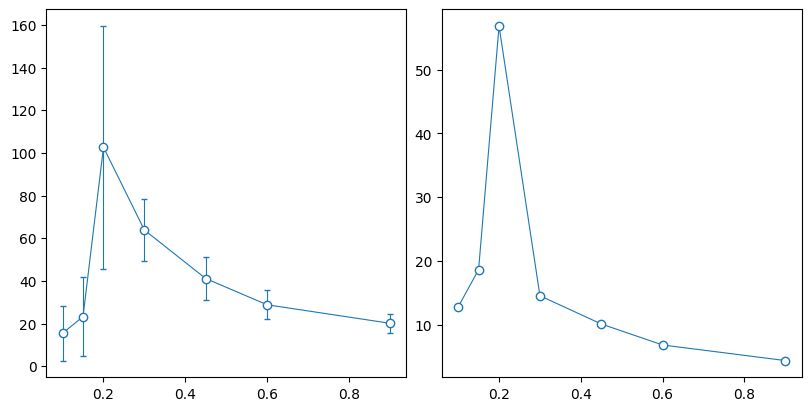

In [26]:
ls = [0.1, 0.15, 0.2, 0.3, 0.45, 0.6, 0.9]
lci = 1.0
# ci_kwargs = [1, 0.3, 10.0]
# ci_kwargs = [0, ]
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

# compare error in the tss with the new method that considers relative difference bumps...
fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
# for tssPath in [f'{resPath}/old_tss/', f'{resPath}/']:
for tssPath in [f'{resPath}/', ]:
    tssEvo, tssStdEvo = [], []
    for l in ls:
        tssFile = f'{tssPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
        tssDf = pd.read_csv(tssFile)
        tss, tssStd = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])
        tssEvo.append(tss), tssStdEvo.append(tssStd)
    ax[0].errorbar(ls, tssEvo, tssStdEvo, marker='o', mfc='w', capsize=2.0, lw=0.8)
    ax[1].plot(ls, tssStdEvo, marker='o', mfc='w', lw=0.8)


# compare the error in the tss if using all times and avg, or tssMax avg
# fig, ax = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

# tssPath = f'{resPath}'
# tssEvo, tssStdEvo = [], []
# tssMaxEvo, tssMaxStdEvo = [], []
# for l in ls:
#     tssFile = f'{tssPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
#     tssDf = pd.read_csv(tssFile)
#     tss, tssStd = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])
#     tssEvo.append(tss), tssStdEvo.append(tssStd)
#     tssMax, tssMaxStd = np.average(tssDf['f0']), np.std(tssDf['f0'])
#     tssMaxEvo.append(tssMax), tssMaxStdEvo.append(tssMaxStd)
# ax[0].errorbar(ls, tssEvo, tssStdEvo, marker='o', mfc='w', capsize=2.0, lw=0.8)
# ax[1].plot(ls, tssStdEvo, marker='o', mfc='w', lw=0.8)
# ax[0].errorbar(ls, tssMaxEvo, tssMaxStdEvo, marker='o', mfc='w', capsize=2.0, lw=0.8)
# ax[1].plot(ls, tssMaxStdEvo, marker='o', mfc='w', lw=0.8)


### generate no cross inhibitio data also

In [31]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
N, maxTime, Nrea, ic = 1000, 100.0, 100, 'N'

lci, ci_kwargs = 0.0, [0, ] # setting linear cross inhibition but with lci=0.0 so it does not make an effect

h=1.0

# l = 0.1
# _, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)

l = 0.3
_, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)

l = 0.6
_, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)

l = 0.9
_, _ = get_data_for_cost_func(h, pis, qs, l, lci, ci_kwargs, N, ic, maxTime, Nrea, execSim=False)


f0        12.000000
f1        82.000000
f2        69.000000
tssMax    82.000000
tssAvg    54.333333
Name: 77, dtype: float64


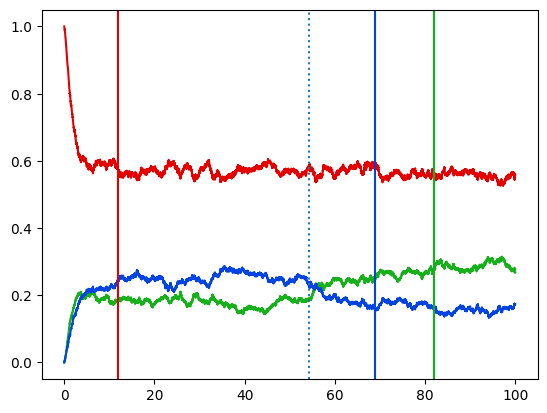

In [30]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

# shit happens in sims with these parameters:
# i = 6
# i = 38
# l, lci = 0.6, 1.0
# ci_kwargs = [1, 0.5, 500.0]

# other tests:
i = 77
l, lci = 0.15, 1.0
ci_kwargs = [0, ]
ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])


df = pd.read_csv(f'{resPath}/sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_1000_ic_N/time_evo_rea_{i}.csv')

dftss = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_1000_ic_N.csv')

fig, ax = plt.subplots()
ax.plot(df['time'], df['f0'], color='xkcd:red')
ax.plot(df['time'], df['f1'], color='xkcd:green')
ax.plot(df['time'], df['f2'], color='xkcd:blue')

ax.axvline(dftss['tssMax'][i])
ax.axvline(dftss['f0'][i], color='xkcd:red')
ax.axvline(dftss['f1'][i], color='xkcd:green')
ax.axvline(dftss['f2'][i], color='xkcd:blue')
ax.axvline(dftss['tssAvg'][i], ls=':')
print(dftss.iloc[i])


0.9615249999999997 0.3545346507504159
0.038474999999999954 0.44989875221098846
------
0.23 0.02931039130434783
0.7700000000000011 0.6643658116883118
------
0.17999999999999997 0.05008455555555556
0.8200000000000008 0.6545405426829267
------


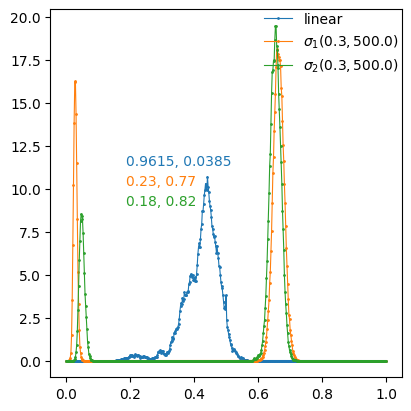

In [52]:
pis, qs, l, lci = [0.1, 0.1], [8.0, 10.0], 0.2, 1.0
# ci_kwargs_list = [[0, ], [1, 0.3, 10.0], [2, 0.3, 10.0]]
ci_kwargs_list = [[0, ], [1, 0.3, 500.0], [2, 0.3, 500.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 10.0], [2, 0.5, 10.0]]
# ci_kwargs_list = [[0, ], [1, 0.5, 500.0], [2, 0.5, 500.0]]
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")

peaksCut = 0.4
peaksAvg = []
peaksProb = []
fig, ax = plt.subplots(1,1,figsize=(4,4), constrained_layout=True)
for i,(ci_kwargs,cilabel) in enumerate(zip(ci_kwargs_list,species)):
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    ssdata_df = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
    fdata = np.array(ssdata_df['f2'])
    hist, bin_edges = np.histogram(fdata, bins=499, range=(0,1.0), density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
    binWidth = bin_edges[1]-bin_edges[0]
    ln, = ax.plot(bin_centers, hist, marker='.', ms=2, lw=0.8, label=cilabel)
    prob1, ssval1 = sum(hist[bin_centers<0.5]*binWidth), np.average(fdata[fdata<peaksCut])
    prob2, ssval2 = sum(hist[bin_centers>=0.5]*binWidth), np.average(fdata[fdata>=peaksCut])
    fig.text(0.3, 0.6-0.05*i, f'{round(prob1,4)}, {round(prob2,4)}', color=ln.get_color())
    print(prob1, ssval1)
    print(prob2, ssval2)
    print('------')
    peaksAvg.extend([ssval1, ssval2])
    peaksProb.extend([prob1, prob2])
    
fig.legend(frameon=False)


In [83]:
pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

sstimes = []
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    fname = f'tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv'
    times_df = pd.read_csv(f'{resPath}/{fname}')
    sstimes.append(np.average(times_df['tss']))

costF_lin = peaksAvg[1]*peaksProb[1]/np.average(sstimes[0])
costF_sig2 = peaksAvg[3]*peaksProb[3]/np.average(sstimes[1])
costF_sig1 = peaksAvg[5]*peaksProb[5]/np.average(sstimes[2])


chi = costF_sig2/costF_lin
print(chi)
chi = costF_sig1/costF_lin
print(chi)

# Cost function for different lambdas

In [53]:
pis, qs, lci = [0.2, 0.2], [9.0, 10.0], 1.0
# pis, qs, lci = [0.2, 0.2], [9.0, 10.0], 1.0
N, ic, NreaStatData = 1000, 'N', 10000

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]

costFuncData = {}

# this is for pis 0.1 0.1, qs 9.0 10.0
# ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
# peaksCut_dic = {
#     (0, ): [0.0, 0.0, 0.4, 0.4, 0.4, 0.4, 0.4],
#     (1, 0.3, 10.0): [0.2, 0.35, 0.4, 0.4, 0.4, 0.4, 0.4],
#     (2, 0.3, 10.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
#     (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
#     (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
# }

# this is for pis 0.2 0.2, qs 9.0 10.0
# pis = [0.2, 0.2]
# peaksCut_dic = {
#     (0, ): [0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5], # probably lambda =0.3 needs more equilibration time...
#     (1, 0.3, 10.0): [0.3, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5],
#     (2, 0.3, 10.0): [0.3, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5],
#     (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5],
#     (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5]
# }

# this si for pis 0.1 0.1, qs 8.0 10.0
pis, qs = [0.1, 0.1], [8.0, 10.0]
peaksCut_dic = {
    (0, ): [0.0, 0.0, 0.25, 0.5, 0.5, 0.5, 0.5],
    (1, 0.3, 10.0): [0.0, 0.25, 0.4, 0.5, 0.5, 0.5, 0.5],
    (2, 0.3, 10.0): [0.0, 0.25, 0.4, 0.5, 0.5, 0.5, 0.5],
    (1, 0.3, 500.0): [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    (2, 0.3, 500.0): [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
}

winerProbData = pd.read_csv(f'{resPath}/winner_perc_data.csv')
winerProbData = winerProbData.query('pi1 == @pis[0] & pi2 == @pis[1] & q1 == @qs[0] & q2 == @qs[1] & lci == @lci & ic == @ic & N == @N ') # & Nrea == @NreaStatData
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    costFuncData[ci_kwargs] = {'f2winVal':[], 'probf2winVal':[], 'tss':[], 'CF':[], 'f2winValerr':[], 'probf2winValerr':[], 'tsserr':[], 'CFerr':[]}
    cistr = str(ci_kwargs)
    for l,peaksCut in zip(ls,peaksCut_dic[ci_kwargs]):
        tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        # time to stationary state:
        tss, tsserr = np.average(tssDf['tssAvg']), np.std(tssDf['tssAvg'])/np.sqrt(len(tssDf['tssAvg']))
        costFuncData[ci_kwargs]['tss'].append(tss), costFuncData[ci_kwargs]['tsserr'].append(tsserr)
        # stationary value when f2 wins:
        f2winVal, f2winValerr = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])/np.sqrt(len(ssDataDf['f2']))
        costFuncData[ci_kwargs]['f2winVal'].append(f2winVal), costFuncData[ci_kwargs]['f2winValerr'].append(f2winValerr)
        ### probability to be in the f2 stationary point:
        hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
        bin_centers, binWidth = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
        probf2win = round(sum(hist[bin_centers>=peaksCut]*binWidth),8)
        probf2winerr = np.sqrt(probf2win*(1-probf2win)/(len(ssDataDf['f2'])/2000))
        # probf2win, NreaStatData = float(winerProbData.query('ci_kwargs == @cistr & l == @l')['f2win'].iloc[0]), float(winerProbData.query('ci_kwargs == @cistr & l == @l')['Nrea'].iloc[0])
        # probf2winerr = np.sqrt(probf2win*(1-probf2win)/NreaStatData)
        costFuncData[ci_kwargs]['probf2winVal'].append(probf2win), costFuncData[ci_kwargs]['probf2winValerr'].append(probf2winerr)
        # once having all the data compute the cost function value, and its std by error propagation:
        cf = probf2win*f2winVal/tss
        cferr = (1/tss)*np.sqrt((probf2win*f2winValerr)**2+(f2winVal*probf2winerr)**2+(f2winVal*probf2win*tsserr/tss)**2)
        costFuncData[ci_kwargs]['CF'].append(cf), costFuncData[ci_kwargs]['CFerr'].append(cferr)

# NO CROSS INHIBITION LIMIT
# costFuncData_lci0 = {'f2winVal':[], 'probf2winVal':[], 'tss':[], 'CF':[]}
# for l in ls:
#     tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_0.0_cikw_0_N_{N}_ic_{ic}.csv')
#     ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_0.0_cikw_0_N_{N}_ic_{ic}.csv')
#     # time to stationary state:
#     tss = np.average(tssDf['tssAvg'])
#     costFuncData_lci0['tss'].append(tss)
#     # stationary value when f2 wins:
#     f2winVal = np.average(ssDataDf['f2'])
#     costFuncData_lci0['f2winVal'].append(f2winVal)
#     # probability to be in the f2 stationary point:
#     hist, bin_edges = np.histogram(ssDataDf['f2'], bins=499, range=(0,1.0), density=True)
#     bin_centers, binWdith = (bin_edges[1:] + bin_edges[:-1])/2, bin_edges[1]-bin_edges[0]
#     # prob1 = sum(hist[bin_centers<0.5]*binWidth)
#     probf2win = sum(hist*binWidth)
#     costFuncData_lci0['probf2winVal'].append(probf2win)
#     # once having all the data compute the cost function value, and its std by error propagation:
#     cf = probf2win*f2winVal/tss
#     costFuncData_lci0['CF'].append(cf)

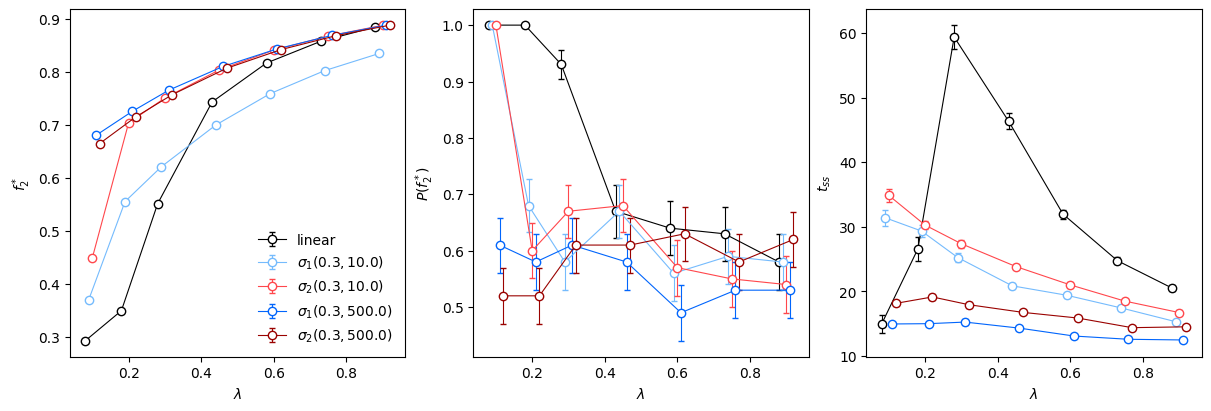

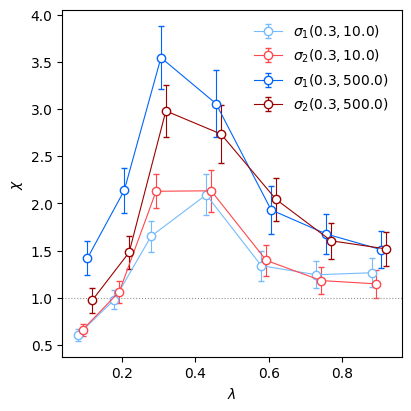

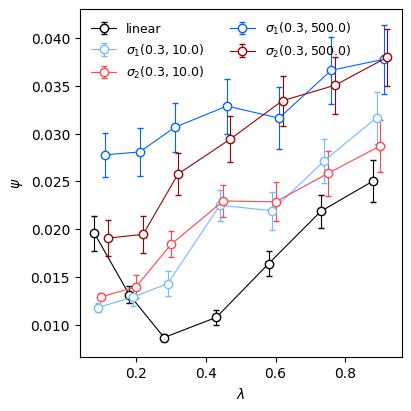

In [54]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
figCF, axCF = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
figProd, axProd = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax[0].set(xlabel='$\lambda$', ylabel='$f_2^*$')
ax[1].set(xlabel='$\lambda$', ylabel='$P(f_2^*)$')
ax[2].set(xlabel='$\lambda$', ylabel=r'$t_{ss}$')
axCF.set(xlabel='$\lambda$', ylabel='$\chi$')
# axProd.set(xlabel='$\lambda$', ylabel='$f_2^* \; P(f_2^*)$')
axProd.set(xlabel='$\lambda$', ylabel='$\psi$')

species = []
for ci_kwargs in ci_kwargs_list:
    if len(ci_kwargs) == 1:
        species.append("linear")
    elif len(ci_kwargs) == 4 and int(ci_kwargs[3]) == 1:
        species.append(fr"$\sigma_{ci_kwargs[0]}^{{lin}} ({ci_kwargs[1]}, {ci_kwargs[2]})$")
    else:
        species.append(fr"$\sigma_{ci_kwargs[0]} ({ci_kwargs[1]}, {ci_kwargs[2]})$")


ebars = True
jitterer = np.linspace(-0.02,0.02, len(ci_kwargs_list))
# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
color_seq = ['k', 'xkcd:sky blue', 'xkcd:light red', 'xkcd:bright blue', 'xkcd:deep red']
if ebars:
    for ci_kwargs, cilabel, c, jit in zip(ci_kwargs_list, species, color_seq, jitterer):
        ax[0].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['f2winVal'], costFuncData[tuple(ci_kwargs)]['f2winValerr'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel, capsize=2.0)
        ax[1].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['probf2winVal'], costFuncData[tuple(ci_kwargs)]['probf2winValerr'], lw=0.8, marker='o', color=c, mfc='w', capsize=2.0)
        ax[2].errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['tss'], costFuncData[tuple(ci_kwargs)]['tsserr'], lw=0.8, marker='o', color=c, mfc='w', capsize=2.0)
        # product of f2* and prob(f2*)
        # prod = np.array(costFuncData[tuple(ci_kwargs)]['f2winVal'])*np.array(costFuncData[tuple(ci_kwargs)]['probf2winVal'])
        # axProd.plot(ls+jit, prod, lw=0.8, marker='o', color=c, mfc='w', label=cilabel) # only the product of f2*probf2
        axProd.errorbar(ls+jit, costFuncData[tuple(ci_kwargs)]['CF'], costFuncData[tuple(ci_kwargs)]['CFerr'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel, capsize=2.0) # the psi function
else:
    for ci_kwargs, cilabel, c in zip(ci_kwargs_list, species, color_seq):
        ax[0].plot(ls, costFuncData[tuple(ci_kwargs)]['f2winVal'], lw=0.8, marker='o', color=c, mfc='w', label=cilabel)
        ax[1].plot(ls, costFuncData[tuple(ci_kwargs)]['probf2winVal'], lw=0.8, marker='o', color=c, mfc='w')
        ax[2].plot(ls, costFuncData[tuple(ci_kwargs)]['tss'], lw=0.8, marker='o', color=c, mfc='w')
ax[0].legend(frameon=False)
axProd.legend(frameon=False, fontsize=9, ncols=2)

# add no cross inhibition data...
# ax[0].plot(ls, costFuncData_lci0['f2winVal'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8, label='No CI')
# ax[1].plot(ls, costFuncData_lci0['probf2winVal'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8)
# ax[2].plot(ls, costFuncData_lci0['tss'], lw=0.9, marker='o', mfc='w', color='k', alpha=0.8)


# lets call the cost function with the greek letter psi, and the ratio with chi
jitterer = np.linspace(-0.02,0.02, len(ci_kwargs_list[1:]))
psiLin, psiLinerr = np.array(costFuncData[(0, )]['CF']), np.array(costFuncData[(0, )]['CFerr'])
for i,(ci_kwargs,cilabel,c,jit) in enumerate(zip(ci_kwargs_list[1:],species[1:],color_seq[1:], jitterer)):
    psiCI, psiCIerr = np.array(costFuncData[tuple(ci_kwargs)]['CF']), np.array(costFuncData[tuple(ci_kwargs)]['CFerr'])
    chi = psiCI/psiLin
    chierr = (1/psiLin)*np.sqrt(psiCIerr**2 + (chi*psiLinerr)**2)
    if ebars:
        axCF.errorbar(ls+jit, chi, chierr, marker='o', mfc='w', color=c, capsize=2.0, lw=0.8, label=cilabel) # to use the standard color sequence: color=f'C{i+1}',
    else:
        axCF.plot(ls, chi, marker='o', mfc='w', color=c, lw=0.8)

axCF.axhline(1.0, 0, 1, ls=':', lw=0.8, color='xkcd:grey')
axCF.legend(frameon=False)


fig.savefig(f'cost_func_data_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')
figCF.savefig(f'chi_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')
figProd.savefig(f'psi_pis_{pichain}_qs_{qchain}_lci_{lci}_N_{N}_ic_{ic}_sig12_dif_a_x0_{ci_kwargs_list[1][1]}.png')

## First passage times over the avg stationary value across many realizations...

In [ ]:
pis, qs, lci = [0.1, 0.1], [9.0, 10.0], 1.0
N, ic = 1000, 'N'

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])

ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.9]
# ci_kwargs_list = [(0, ), (1, 0.3, 10.0), (2, 0.3, 10.0), (1, 0.3, 500.0), (2, 0.3, 500.0)]
ci_kwargs_list = [(0, ), ]

peaksCut_dic = {
    (0, ): [0.0, 0.0, 0.4, 0.4, 0.4, 0.4],
    (1, 0.3, 10.0): [0.2, 0.35, 0.4, 0.4, 0.4, 0.4],
    (2, 0.3, 10.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
    (1, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
    (2, 0.3, 500.0): [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
}

fptimes_dic = {}
for ci_kwargs in ci_kwargs_list:
    ci_kwargs_chain = '_'.join([str(cikw) for cikw in ci_kwargs])
    fptimes_dic[tuple(ci_kwargs)] = {}
    for l,peaksCut in zip(ls,peaksCut_dic[ci_kwargs]):
        ### tssDf = pd.read_csv(f'{resPath}/tss_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        # stationary value when f2 wins:
        ssDataDf = pd.read_csv(f'{resPath}/ss_data_from_sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}.csv')
        f2winVal, f2winValstd = np.average(ssDataDf['f2'][ssDataDf['f2']>=peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']>=peaksCut])
        f2loseVal, f2loseValstd = np.average(ssDataDf['f2'][ssDataDf['f2']<peaksCut]), np.std(ssDataDf['f2'][ssDataDf['f2']<peaksCut])
        # get first passage time from time evolutions...
        evoName = f'sim_results_evos_pis_{pichain}_qs_{qchain}_l_{l}_lci_{lci}_cikw_{ci_kwargs_chain}_N_{N}_ic_{ic}'
        evoFiles = glob.glob(f'{resPath}/{evoName}/*')
        fptimes = []
        for i in range(len(evoFiles)):
            f = f'{resPath}/{evoName}/time_evo_rea_{i}.csv'
            tevo = pd.read_csv(f)
            tevo['f2winValdif'] = abs(tevo['f2'] - f2winVal)
            tevo['f2loseValdif'] = abs(tevo['f2'] - f2loseVal)
            thresh = 0.8*f2winValstd
            times = list(tevo.query('f2winValdif < @thresh & time > 2.0')['time'])
            if len(times) == 0:
                thresh = 0.8*f2loseValstd
                times = list(tevo.query('f2loseValdif < @f2loseValstd & time > 2.0')['time'])
            if len(times) > 0:
                fptimes.append(times[0])
            else:
                print(f'could not find fpt for rea {i} with ci_kwargs = {ci_kwargs} and l = {l}')
        fptimes_dic[tuple(ci_kwargs)][l] = fptimes


fptAvg_l, fptStd_l = [], []
for l,fptimes in fptimes_dic[(0, )].items():
    fptavg, fptstd = np.average(fptimes), np.std(fptimes)
    fptAvg_l.append(fptavg), fptStd_l.append(fptstd)
print(fptAvg_l)
print(fptStd_l)

# Estimate winner probabilities from the autoStop gillespie program

## comparison between data computed from "cost func data" and dedicated simulations

<ErrorbarContainer object of 3 artists>

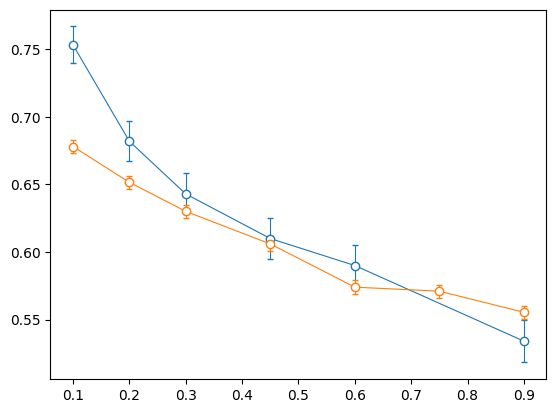

In [35]:
pis, qs, lci = [0.2, 0.2], [9.0, 10.0], 1.0
N, ic = 1000, 'N'

ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.75, 0.9]
ls = [0.1, 0.2, 0.3, 0.45, 0.6, 0.9]
ci_kwargs = [1, 0.3, 10.0]

fig, ax = plt.subplots()

# cost function data
ax.errorbar(ls, costFuncData[tuple(ci_kwargs)]['probf2winVal'], costFuncData[tuple(ci_kwargs)]['probf2winValerr'], lw=0.8, marker='o', mfc='w', capsize=2.0)

dfwinf = pd.read_csv(f'{resPath}/winner_perc_data.csv')
cistr = str(tuple(ci_kwargs))
dfwinf = dfwinf.query('ci_kwargs == @cistr & pi1 == @pis[0] & pi2 == @pis[1]').copy()
dfwinf['f2winerr'] = np.sqrt(dfwinf['f2win']*(1-dfwinf['f2win'])/dfwinf['Nrea'])
ax.errorbar(dfwinf['l'], dfwinf['f2win'], dfwinf['f2winerr'], lw=0.8, marker='o', mfc='w', capsize=2.0)